version 1

In [4]:
from efficient_apriori import apriori
import pandas as pd

data = [[1, 3, 4], [2, 3, 5], [1, 2, 3, 5], [2, 5]]


# 挖掘频繁项集和关联规则
itemsets, rules = apriori(data,  min_support=0.5,  min_confidence=1)
print('频繁项集：', itemsets)
print('关联规则：', rules)

频繁项集： {1: {(1,): 2, (3,): 3, (2,): 3, (5,): 3}, 2: {(1, 3): 2, (2, 3): 2, (2, 5): 3, (3, 5): 2}, 3: {(2, 3, 5): 2}}
关联规则： [{1} -> {3}, {5} -> {2}, {2} -> {5}, {3, 5} -> {2}, {2, 3} -> {5}]


频繁项集指的是在数据集中频繁出现的项集（可以是一个也可以是多个）  
如果事件A中包含k个元素，那么称这个事件A为k项集，并且事件A满足最小支持度阈值的事件称为频繁k项集  
对于Apriori算法，我们使用支持度来作为我们判断频繁项集的标准。Apriori算法的目标是找到最大的K项频繁集。

version 2

In [5]:
import sys

from itertools import chain, combinations
from collections import defaultdict
from optparse import OptionParser


def subsets(arr):
    """ Returns non empty subsets of arr"""
    return chain(*[combinations(arr, i + 1) for i, a in enumerate(arr)])


def returnItemsWithMinSupport(itemSet, transactionList, minSupport, freqSet):
    """calculates the support for items in the itemSet and returns a subset
    of the itemSet each of whose elements satisfies the minimum support"""
    _itemSet = set()
    localSet = defaultdict(int)

    for item in itemSet:
        for transaction in transactionList:
            if item.issubset(transaction):
                freqSet[item] += 1
                localSet[item] += 1

    for item, count in localSet.items():
        support = float(count) / len(transactionList)

        if support >= minSupport:
            _itemSet.add(item)

    return _itemSet


def joinSet(itemSet, length):
    """Join a set with itself and returns the n-element itemsets"""
    return set(
        [i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length]
    )


def getItemSetTransactionList(data_iterator):
    transactionList = list()
    itemSet = set()
    for record in data_iterator:
        transaction = frozenset(record)
        transactionList.append(transaction)
        for item in transaction:
            itemSet.add(frozenset([item]))  # Generate 1-itemSets
    return itemSet, transactionList


def runApriori(data_iter, minSupport, minConfidence):
    """
    run the apriori algorithm. data_iter is a record iterator
    Return both:
     - items (tuple, support)
     - rules ((pretuple, posttuple), confidence)
    """
    itemSet, transactionList = getItemSetTransactionList(data_iter)

    freqSet = defaultdict(int)
    largeSet = dict()
    # Global dictionary which stores (key=n-itemSets,value=support)
    # which satisfy minSupport

    assocRules = dict()
    # Dictionary which stores Association Rules

    oneCSet = returnItemsWithMinSupport(itemSet, transactionList, minSupport, freqSet)

    currentLSet = oneCSet
    k = 2
    while currentLSet != set([]):
        largeSet[k - 1] = currentLSet
        currentLSet = joinSet(currentLSet, k)
        currentCSet = returnItemsWithMinSupport(
            currentLSet, transactionList, minSupport, freqSet
        )
        currentLSet = currentCSet
        k = k + 1

    def getSupport(item):
        """local function which Returns the support of an item"""
        return float(freqSet[item]) / len(transactionList)

    toRetItems = []
    for key, value in largeSet.items():
        toRetItems.extend([(tuple(item), getSupport(item)) for item in value])

    toRetRules = []
    for key, value in list(largeSet.items())[1:]:
        for item in value:
            _subsets = map(frozenset, [x for x in subsets(item)])
            for element in _subsets:
                remain = item.difference(element)
                if len(remain) > 0:
                    confidence = getSupport(item) / getSupport(element)
                    if confidence >= minConfidence:
                        toRetRules.append(((tuple(element), tuple(remain)), confidence))
    return toRetItems, toRetRules


def printResults(items, rules):
    """prints the generated itemsets sorted by support and the confidence rules sorted by confidence"""
    for item, support in sorted(items, key=lambda x: x[1]):
        print("item: %s , %.3f" % (str(item), support))
    print("\n------------------------ RULES:")
    for rule, confidence in sorted(rules, key=lambda x: x[1]):
        pre, post = rule
        print("Rule: %s ==> %s , %.3f" % (str(pre), str(post), confidence))


def to_str_results(items, rules):
    """prints the generated itemsets sorted by support and the confidence rules sorted by confidence"""
    i, r = [], []
    for item, support in sorted(items, key=lambda x: x[1]):
        x = "item: %s , %.3f" % (str(item), support)
        i.append(x)

    for rule, confidence in sorted(rules, key=lambda x: x[1]):
        pre, post = rule
        x = "Rule: %s ==> %s , %.3f" % (str(pre), str(post), confidence)
        r.append(x)

    return i, r


def dataFromFile(fname):
    """Function which reads from the file and yields a generator"""
    with open(fname, "rU") as file_iter:
        for line in file_iter:
            line = line.strip().rstrip(",")  # Remove trailing comma
            record = frozenset(line.split(","))
            yield record

In [8]:
minSupport = 0.5
minConfidence = 1

items, rules = runApriori(data, minSupport, minConfidence)
printResults(items, rules)

item: (1,) , 0.500
item: (1, 3) , 0.500
item: (2, 3) , 0.500
item: (3, 5) , 0.500
item: (2, 3, 5) , 0.500
item: (3,) , 0.750
item: (2,) , 0.750
item: (5,) , 0.750
item: (2, 5) , 0.750

------------------------ RULES:
Rule: (2,) ==> (5,) , 1.000
Rule: (5,) ==> (2,) , 1.000
Rule: (1,) ==> (3,) , 1.000
Rule: (2, 3) ==> (5,) , 1.000
Rule: (3, 5) ==> (2,) , 1.000


In [12]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import pandas as pd

In [13]:
data = [[1, 1, 0, 0], [0, 1, 1, 0], [1, 0, 0, 1], [1, 0, 0, 0]]

data = pd.DataFrame(data, columns=['f1', 'f2', 'f3', 'f4'])

In [16]:
data

,f1,f2,f3,f4
0,1,1,0,0
1,0,1,1,0
2,1,0,0,1
3,1,0,0,0


可借助下面这张图理解数据的输入格式。索引代表了商场购买东西的事务，实际购买到的东西组成了项集。

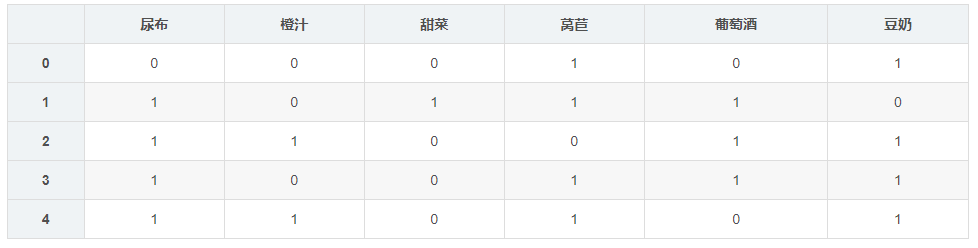

In [13]:
frequent_itemsets = apriori(data, min_support=0.05, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

In [14]:
frequent_itemsets

,support,itemsets
0,0.75,(f1)
1,0.50,(f2)
2,0.25,(f3)
3,0.25,(f4)
4,0.25,"(f1, f2)"
5,0.25,"(f1, f4)"
6,0.25,"(f3, f2)"


In [15]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(f4),(f1),0.25,0.75,0.25,1.0,1.333333,0.0625,inf
1,(f3),(f2),0.25,0.50,0.25,1.0,2.000000,0.1250,inf
